# RF Impairments

When RF signals travel through the air from a transmitter to a receiver they get affected by a great deal of channel effects which must be dealt with to recover the data. But in order to combat the impairments, we should at least understand what they look like and what causes them.

In [3]:
# import sys
# sys.path.insert(0, '../')
# from comms import awgn

import numpy as np
import matplotlib.pyplot as plt

Define some helper functions

In [32]:
# Function to generate QPSK
def generate_qpsk(num_symbols):
    qpsk_scheme= [1+1j, 1-1j, -1+1j, -1-1j]
    ints = np.random.randint(0,4,num_symbols)
    qpsk_symbols = np.array([qpsk_scheme[i] for i in ints])/np.sqrt(2)
    
    return qpsk_symbols, ints

def make_rrc(num_weights=41, alpha=0.35, fs=5):
    Ts =  1/fs
    
    # Calculate time indexes of filter weights
    x = np.arange(-int(num_weights/2),int(num_weights/2),1)/fs
    
    # Preallocate memory for filter weights
    h_rrc = np.zeros(num_weights,)

    # Check for special cases, otherwise apply the main formula
    for idx, weight in enumerate(x):
        if weight == Ts/(4*alpha):
            h_rrc[idx] = (alpha/np.sqrt(2))*(((1+2/np.pi) * (np.sin(np.pi/(4*alpha)))) + ((1-2/np.pi)*(np.cos(np.pi/(4*alpha)))))
        elif weight == -Ts/(4*alpha):
            h_rrc[idx] = (alpha/np.sqrt(2))*(((1+2/np.pi) * (np.sin(np.pi/(4*alpha)))) + ((1-2/np.pi)*(np.cos(np.pi/(4*alpha)))))
        elif weight == 0:
            h_rrc[int(num_weights/2)] = 1/Ts*(1+alpha*(4/np.pi - 1))
        else:
            h_rrc[idx] = 1/Ts*(np.sin(np.pi*weight*(1-alpha)) + 4*alpha*weight*np.cos(np.pi*weight*(1+alpha)))/(np.pi*weight*(1-(4*alpha*weight)**2))
            
    # Normalize the weights
    h_rrc = h_rrc/np.max(h_rrc)
    
    return h_rrc

def pulse_shape(symbols, hrrc, sps=4):
    
    num_weights = len(hrrc)
    
    padded_symbols = np.zeros(len(symbols)*sps, dtype=complex)
    padded_symbols[np.arange(0,len(padded_symbols),sps)] = symbols
    
    # to take care of the transient we append a bunch of zeros
    shaped_symbols = np.convolve(np.concatenate((np.zeros(int((num_weights-1)/2)),padded_symbols)), hrrc, mode='same')
    
    return shaped_symbols[int((num_weights-1)/2):]

What is AWGN? Just samples added form a normal distribution.

In [23]:
noise = np.random.randn(5000,1)
print(np.mean(noise))
print(np.var(noise))

-0.001059998355597922
1.02923828451785


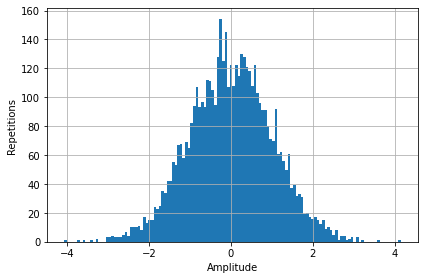

In [24]:
plt.hist(noise, bins=128)
plt.xlabel('Amplitude'); plt.ylabel('Repetitions')
plt.tight_layout()
# plt.savefig('figures/noise.svg', dpi=300)

We can change the variance of the noise by multiplying these samples by the square root ouf our desired new variance. E.g. multiply by 2, the new variance is ~4. This is how we can vary the noise level when adding AWGN to a channel.

In [25]:
noise = 2*np.random.randn(5000,1)
print(np.mean(noise))
print(np.var(noise))

0.002227271940586043
3.9651129543571892


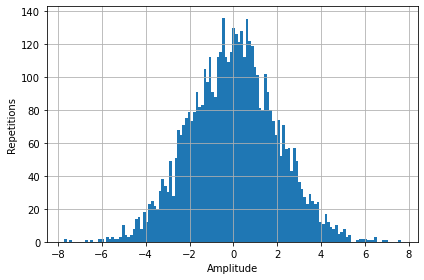

In [26]:
plt.hist(noise, bins=128)
plt.xlabel('Amplitude'); plt.ylabel('Repetitions')
plt.tight_layout()

## Generate some data

We'll generate a simple QPSK signal

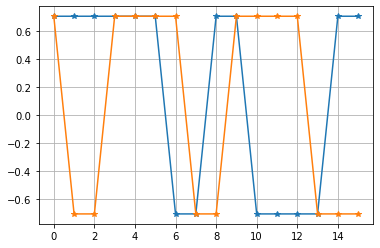

In [27]:
samples, _ = generate_qpsk(16)
plt.plot(samples.real, '-*')
plt.plot(samples.imag, '-*')
plt.grid()

Pulse shape the symbols

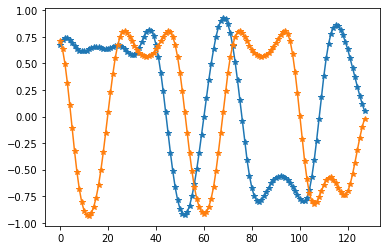

In [28]:
hrrc = make_rrc(num_weights=65, fs=8)
samples_rrc = pulse_shape(samples, hrrc, sps=8)

plt.plot(samples_rrc.real, '-*')
plt.plot(samples_rrc.imag, '-*')

Visualize the effects of pulse shaping on the constellation plot. The one on the right already makes it a little bit more difficult to discern what modulation scheme it is, doesn't it?

Text(0.5, 1.0, 'QPSK Pulse shaped')

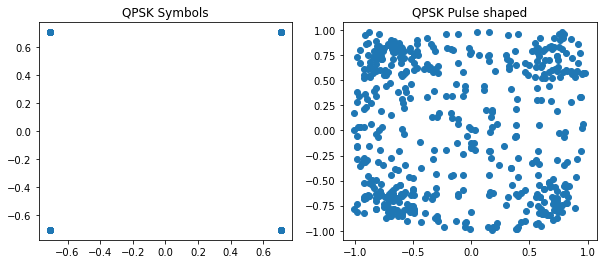

In [29]:
samples, _ = generate_qpsk(64)
hrrc = make_rrc(num_weights=65, fs=8)
samples_rrc = pulse_shape(samples, hrrc, sps=8)

fix, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(samples.real, samples.imag, 'o')
ax[0].set_title('QPSK Symbols')
ax[1].plot(samples_rrc.real, samples_rrc.imag, 'o')
ax[1].set_title('QPSK Pulse shaped')

## Channel effects

### Clean channel

First we'll just look at the clean signals.

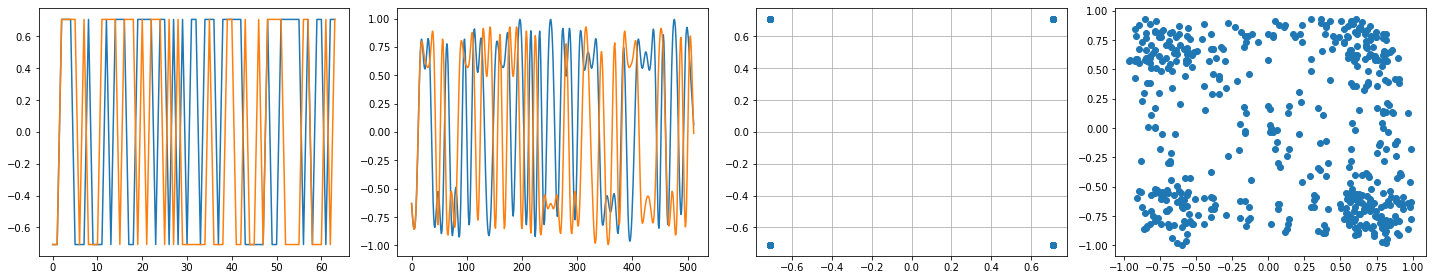

In [11]:
samples, _ = generate_qpsk(64)
hrrc = make_rrc(num_weights=65, fs=8)
samples_rrc = pulse_shape(samples, hrrc, sps=8)

fix, ax = plt.subplots(1,4,figsize=(20,4))
ax[0].plot(samples.real); ax[0].plot(samples.imag)
ax[2].plot(samples.real, samples.imag, 'o')
ax[2].grid()
ax[1].plot(samples_rrc.real); ax[1].plot(samples_rrc.imag)
ax[3].plot(samples_rrc.real, samples_rrc.imag, 'o')
plt.tight_layout()

## AWGN

Now add some AWGN. Let's define a basic awgn function (similar to what you see in MATLAB).

In [33]:
def awgn(signal: np.ndarray, SNR: float, measured: bool=True) -> np.ndarray:
    
    # Calculate signal power
    s_p = np.mean(abs(signal)**2)
    
    # Calculate noise power
    n_p = s_p/(10 **(SNR/10))
    
    # Generate complex noise
    noise = np.sqrt(n_p/2)*(np.random.randn(*signal.shape) + \
                                np.random.randn(*signal.shape)*1j)
    
    # Add signal and noise
    signal_noisy = signal + noise 
    
    return signal_noisy 

Now we can add noise to our pulse shaped symbols and visualize the effects... Note that they're no longer nice little concentrated dots on the constellation diagram.

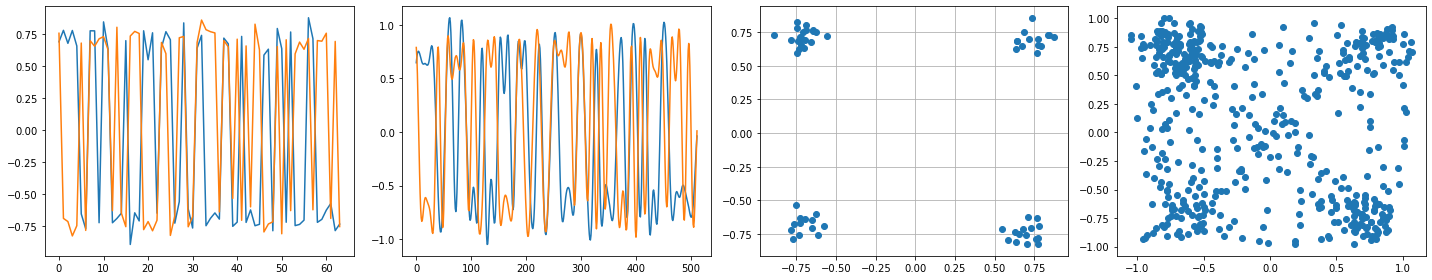

In [36]:
samples, _ = generate_qpsk(64)
samples = awgn(samples, 20)
hrrc = make_rrc(num_weights=65, fs=8)
samples_rrc = pulse_shape(samples, hrrc, sps=8)

fix, ax = plt.subplots(1,4,figsize=(20,4))
ax[0].plot(samples.real); ax[0].plot(samples.imag)
ax[2].plot(samples.real, samples.imag, 'o')
ax[2].grid()
ax[1].plot(samples_rrc.real); ax[1].plot(samples_rrc.imag)
ax[3].plot(samples_rrc.real, samples_rrc.imag, 'o')
plt.tight_layout()

If you lower SNR even more, then your data gets all jambled and good luck with recovering that... Of course with lots and lots of channel coding (redudancy bits) and low order modulation schemes we might get some data out of this mess.

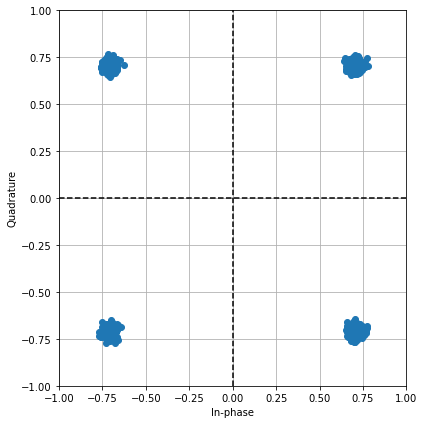

In [42]:
symbols, _ = generate_qpsk(1000)
symbols = awgn(symbols,30)
plt.figure(figsize=(6,6))
plt.plot(symbols.real, symbols.imag, 'o')
plt.grid()
plt.ylim((-1,1));plt.xlim((-1,1))
plt.axvline(0, color='black', linestyle='dashed')
plt.axhline(0, color='black', linestyle='dashed')
plt.xlabel('In-phase'); plt.ylabel('Quadrature')
# plt.title('QPSK Symbols')
plt.tight_layout()
# plt.savefig('figures/qpsk_30db.png', dpi=300, bbox_inches='tight')

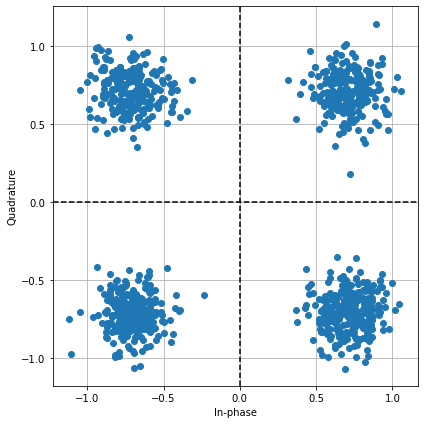

In [43]:
symbols, _ = generate_qpsk(1000)
symbols = awgn(symbols,15)
plt.figure(figsize=(6,6))
plt.plot(symbols.real, symbols.imag, 'o')
plt.grid()
plt.xlabel('In-phase'); plt.ylabel('Quadrature')
plt.axvline(0, color='black', linestyle='dashed')
plt.axhline(0, color='black', linestyle='dashed')
plt.tight_layout()
# plt.savefig('figures/qpsk_15db.png', dpi=300, bbox_inches='tight')

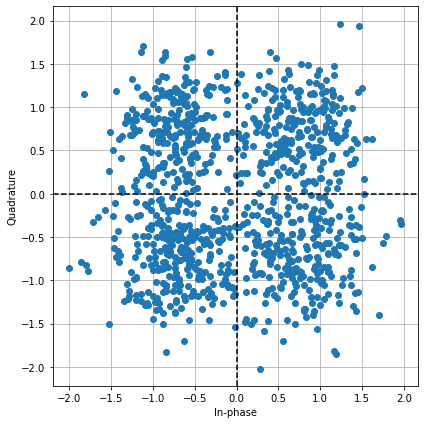

In [44]:
symbols, _ = generate_qpsk(1000)
symbols = awgn(symbols,5)
plt.figure(figsize=(6,6))
plt.plot(symbols.real, symbols.imag, 'o')
plt.grid()
plt.xlabel('In-phase'); plt.ylabel('Quadrature')
plt.axvline(0, color='black', linestyle='dashed')
plt.axhline(0, color='black', linestyle='dashed')
plt.tight_layout()
# plt.savefig('figures/qpsk_5db.png', dpi=300, bbox_inches='tight')

## Phase offset

Phase offset is a fairly straightforward concept -- it's a constant rotation of the samples around the origin of the constellation plots. We can implement it using numpy angles.

In [38]:
# add phase offset in degrees
def phase_offset(x, offset):
    
    # Convert to polar form so we can add degrees
    mag, ang = np.abs(x), np.angle(x, deg=True)
    
    return mag * np.exp( 1j * ((ang + offset)*np.pi/180) )

Now we see our original constellation has been rotated by 30 degrees. Small offsets like this won't cause bit errors. Large ones will require correction.

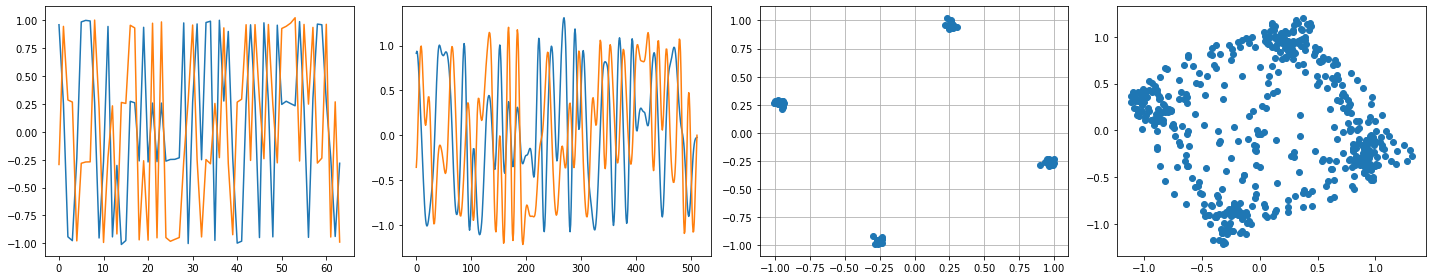

In [39]:
samples, _ = generate_qpsk(64)
samples = phase_offset(samples,offset=30)
samples = awgn(samples, 30)
hrrc = make_rrc(num_weights=65, fs=8)
samples_rrc = pulse_shape(samples, hrrc, sps=8)

fix, ax = plt.subplots(1,4,figsize=(20,4))
ax[0].plot(samples.real); ax[0].plot(samples.imag)
ax[2].plot(samples.real, samples.imag, 'o')
ax[2].grid()
ax[1].plot(samples_rrc.real); ax[1].plot(samples_rrc.imag)
ax[3].plot(samples_rrc.real, samples_rrc.imag, 'o')
plt.tight_layout()

## Frequency Offset

Carrier Frequency Offset (CFO), unlike phase offset, is a continuous rotation of the signal. I.e. the phase is constantly changing. For a small offset $\Delta f$, constellations can still be recoverable.

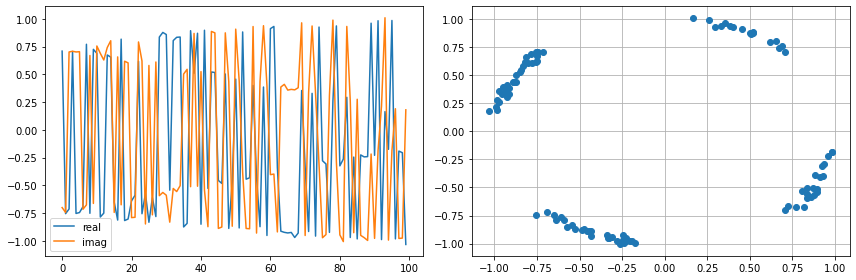

In [40]:
samples, _ = generate_qpsk(100)
# samples = np.ones(100)+1j*np.zeros(100)

offset_sine = np.exp(1j*2*np.pi*(1e3/1e6)*np.arange(len(samples)))
samples = samples*offset_sine

samples = awgn(samples,30)

fix, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(samples.real); ax[0].plot(samples.imag)
ax[1].plot(samples.real, samples.imag, 'o')
# ax[0].plot(np.angle(offset_sine)/np.pi)
# ax[0].plot(offset_sine.real)
# ax[0].plot(offset_sine.imag)
ax[1].grid()
ax[0].legend(('real', 'imag', 'sin r', 'sin i'))
plt.tight_layout()

For large $\Delta f$ the constellation is a circle. You may have seen something like this if you ever used an SDR to lock onto a transmitted QAM signal.

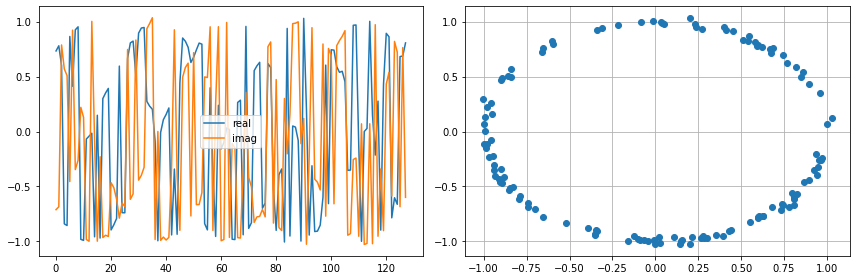

In [41]:
samples, _ = generate_qpsk(128)
# samples = np.ones(100)+1j*np.zeros(100)

offset_sine = np.exp(1j*2*np.pi*(1e4/1e6)*np.arange(len(samples)))
samples = samples*offset_sine

samples = awgn(samples,30)

fix, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(samples.real); ax[0].plot(samples.imag)
ax[1].plot(samples.real, samples.imag, 'o')
# ax[0].plot(np.angle(offset_sine)/np.pi)
# ax[0].plot(np.angle(offset_sine))
# ax[0].plot(offset_sine.real)
# ax[0].plot(offset_sine.imag)
ax[1].grid()
ax[0].legend(('real', 'imag', 'sin r', 'sin i'))
plt.tight_layout()

## Fading channels

A flat fading channel (single tap) is just a complex weight you multiply your signal by. This will cause some attenuation and a phase offset. Typically these aren't as scary as multipath fading channels.

Text(12.25, 0.5, 'Quadrature')

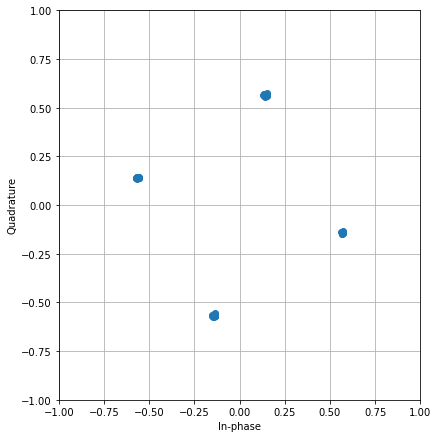

In [45]:
samples, _ = generate_qpsk(100)
# samples = np.ones(100)+1j*np.zeros(100)

complex_weight = [0.3-0.5j]
samples = np.convolve(samples,complex_weight)

samples = awgn(samples,40)

plt.figure(figsize=(6,6))
plt.plot(samples.real, samples.imag, 'o')
plt.grid()
plt.ylim((-1,1)); plt.xlim((-1,1))
plt.tight_layout()
plt.xlabel('In-phase'); plt.ylabel('Quadrature')
# plt.savefig('figures/flat_channel.png', dpi=300, bbox_inches='tight')

Multipath channels are more difficult... They're composed of multiple complex weights, and can be spread over different time intervals. Below is a very simplified implemention where 3-tap multipath filter is convolved with our QPSK signal. We can see that even this simple example already makes it quite difficult to discern the modulation order of our transmitted bits.

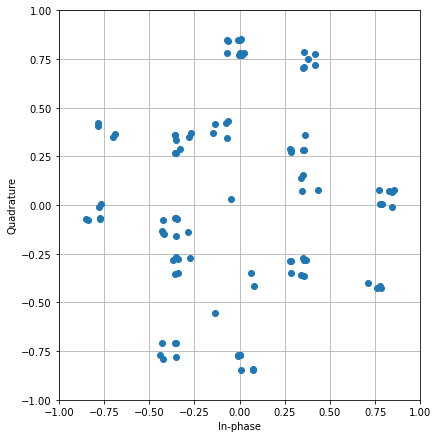

In [69]:
samples, _ = generate_qpsk(100)
# samples = np.ones(100)+1j*np.zeros(100)

complex_weight = [0.3-0.5j, 0.05+0.3j, 0.05+0.001j]
samples = np.convolve(samples,complex_weight)

samples = awgn(samples,40)

plt.figure(figsize=(6,6))
plt.plot(samples.real, samples.imag, 'o')
plt.grid()
plt.ylim((-1,1)); plt.xlim((-1,1))
plt.tight_layout()
plt.xlabel('In-phase'); plt.ylabel('Quadrature')
# plt.savefig('figures/multipath_channel.png', dpi=300, bbox_inches='tight')